In [1]:
from openslide import open_slide
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw
from glob import glob
from tqdm import tqdm
import pandas as pd

In [2]:
SOURCE_DIR = os.path.expanduser('~/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/')
DEST_DIR = '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/bounding_boxes/mask/'

In [3]:
slide_img_paths = [x for x in glob(SOURCE_DIR + 'tumor*.tif') if 'mask.tif' not in x]

In [159]:
slide_img_paths

['/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/tumor_023.tif',
 '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/tumor_019.tif',
 '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/tumor_096.tif',
 '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/tumor_031.tif',
 '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/tumor_016.tif',
 '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/tumor_059.tif',
 '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/tumor_012.tif',
 '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/tumor_064.tif',
 '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/tumor_101.tif',
 '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/tumor_084.tif',
 '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/tumor_078.tif',
 '/home/sj

In [210]:
sample_img_id = '031'
sample_img_path = '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/tumor_{}.tif'.format(sample_img_id)
sample_mask_path = '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/tumor_{}_mask.tif'.format(sample_img_id)

In [211]:
sample_slide = open_slide(sample_img_path)
sample_mask = open_slide(sample_mask_path)

In [212]:
sample_slide.level_downsamples

(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)

In [213]:
sample_slide.level_downsamples[2], sample_slide.level_downsamples[5]

(4.0, 32.0)

In [214]:
len(slide_img_paths)

22

In [215]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
# def read_slide(slide, x, y, level, width, height, as_float=False):
#     im = slide.read_region((x,y), level, (width, height))
#     im = im.convert('RGB') # drop the alpha channel
#     if as_float:
#         im = np.asarray(im, dtype=np.float32)
#     else:
#         im = np.asarray(im)
#     assert im.shape == (height, width, 3)
#     return im

def read_slide_pil(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    return im

In [216]:
def get_normal_image_contours(cont_img, rgb_image, cont_img_tmp):
    contours, _ = cv2.findContours(cont_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_tmp, _ = cv2.findContours(cont_img_tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # print(contours)
    boundingBoxes = [cv2.boundingRect(c) for c in contours]
    # print(boundingBoxes)
    contours_rgb_image_array = np.array(rgb_image)
    contours_rgb_image_array_tmp = np.array(rgb_image)

    line_color = (255, 0, 0)  # blue color code
    cv2.drawContours(contours_rgb_image_array, contours, -1, line_color, 3)
    cv2.drawContours(contours_rgb_image_array_tmp, contours_tmp, -1, line_color, 3)
    # cv2.drawContours(mask_image, contours_mask, -1, line_color, 3)
    return contours_rgb_image_array, boundingBoxes, contours_rgb_image_array_tmp

In [217]:
def draw_bbox(slide_pil_img, bounding_boxes):
    draw = ImageDraw.Draw(slide_pil_img)
    for i, bounding_box in enumerate(bounding_boxes):
        x = int(bounding_box[0])
        y = int(bounding_box[1])
        thickness = 5
        for offset in range(thickness):
            draw.rectangle([x + offset, y + offset, x + offset + bounding_box[2], y + offset + bounding_box[3]],
                           outline=(255, 0, 0))

In [218]:
def get_slide_with_bounding_box(slide):
    slide_pil_image = read_slide_pil(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])
    
    slide_img = np.array(slide_pil_image)
    
    hsv = cv2.cvtColor(slide_img, cv2.COLOR_BGR2HSV)
        # [20, 20, 20]
    lower_red = np.array([50, 50, 50])
    # [255, 255, 255]
    upper_red = np.array([200, 200, 200])
    mask = cv2.inRange(hsv, lower_red, upper_red)
    res = cv2.bitwise_and(slide_img, slide_img, mask=mask)

    # (50, 50)
#     close_kernel = np.ones((20, 20), dtype=np.uint8)
#     close_kernel_tmp = np.ones((50, 50), dtype=np.uint8)
    close_kernel = np.ones((50, 50), dtype=np.uint8)
    close_kernel_tmp = np.ones((30, 30), dtype=np.uint8)
    image_close = Image.fromarray(cv2.morphologyEx(np.array(mask), cv2.MORPH_CLOSE, close_kernel))
    image_close_tmp = Image.fromarray(cv2.morphologyEx(np.array(mask), cv2.MORPH_CLOSE, close_kernel_tmp))
    # (30, 30)
#     open_kernel = np.ones((5, 5), dtype=np.uint8)
#     open_kernel_tmp = np.ones((30, 30), dtype=np.uint8)
    open_kernel = np.ones((30, 30), dtype=np.uint8)
    open_kernel_tmp = np.ones((30, 30), dtype=np.uint8)
    image_open = Image.fromarray(cv2.morphologyEx(np.array(image_close), cv2.MORPH_OPEN, open_kernel))
    image_open_tmp = Image.fromarray(cv2.morphologyEx(np.array(image_close_tmp), cv2.MORPH_OPEN, open_kernel_tmp))
    contour_rgb, bounding_boxes, contour_rgb_tmp = get_normal_image_contours(np.array(image_open),
                                                                                  slide_img,
                                                                                  np.array(image_open_tmp))
    
    
    draw_bbox(slide_pil_image, bounding_boxes)
    return image_open, contour_rgb

In [219]:
sample_slide_pil_mask = read_slide_pil(sample_mask, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=sample_slide.level_dimensions[5][0], 
                         height=sample_slide.level_dimensions[5][1])

In [220]:
sample_mask_arr = np.asarray(sample_slide_pil_mask)[:, :, 0]

In [221]:
sample_slide_pil_image = read_slide_pil(sample_slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=sample_slide.level_dimensions[5][0], 
                         height=sample_slide.level_dimensions[5][1])
    
sample_slide_img_arr = np.array(sample_slide_pil_image)

image_open, contour_rgb = get_slide_with_bounding_box(sample_slide)

In [222]:
image_open_arr = np.asarray(image_open)

In [223]:
image_open_arr.shape

(6912, 3056)

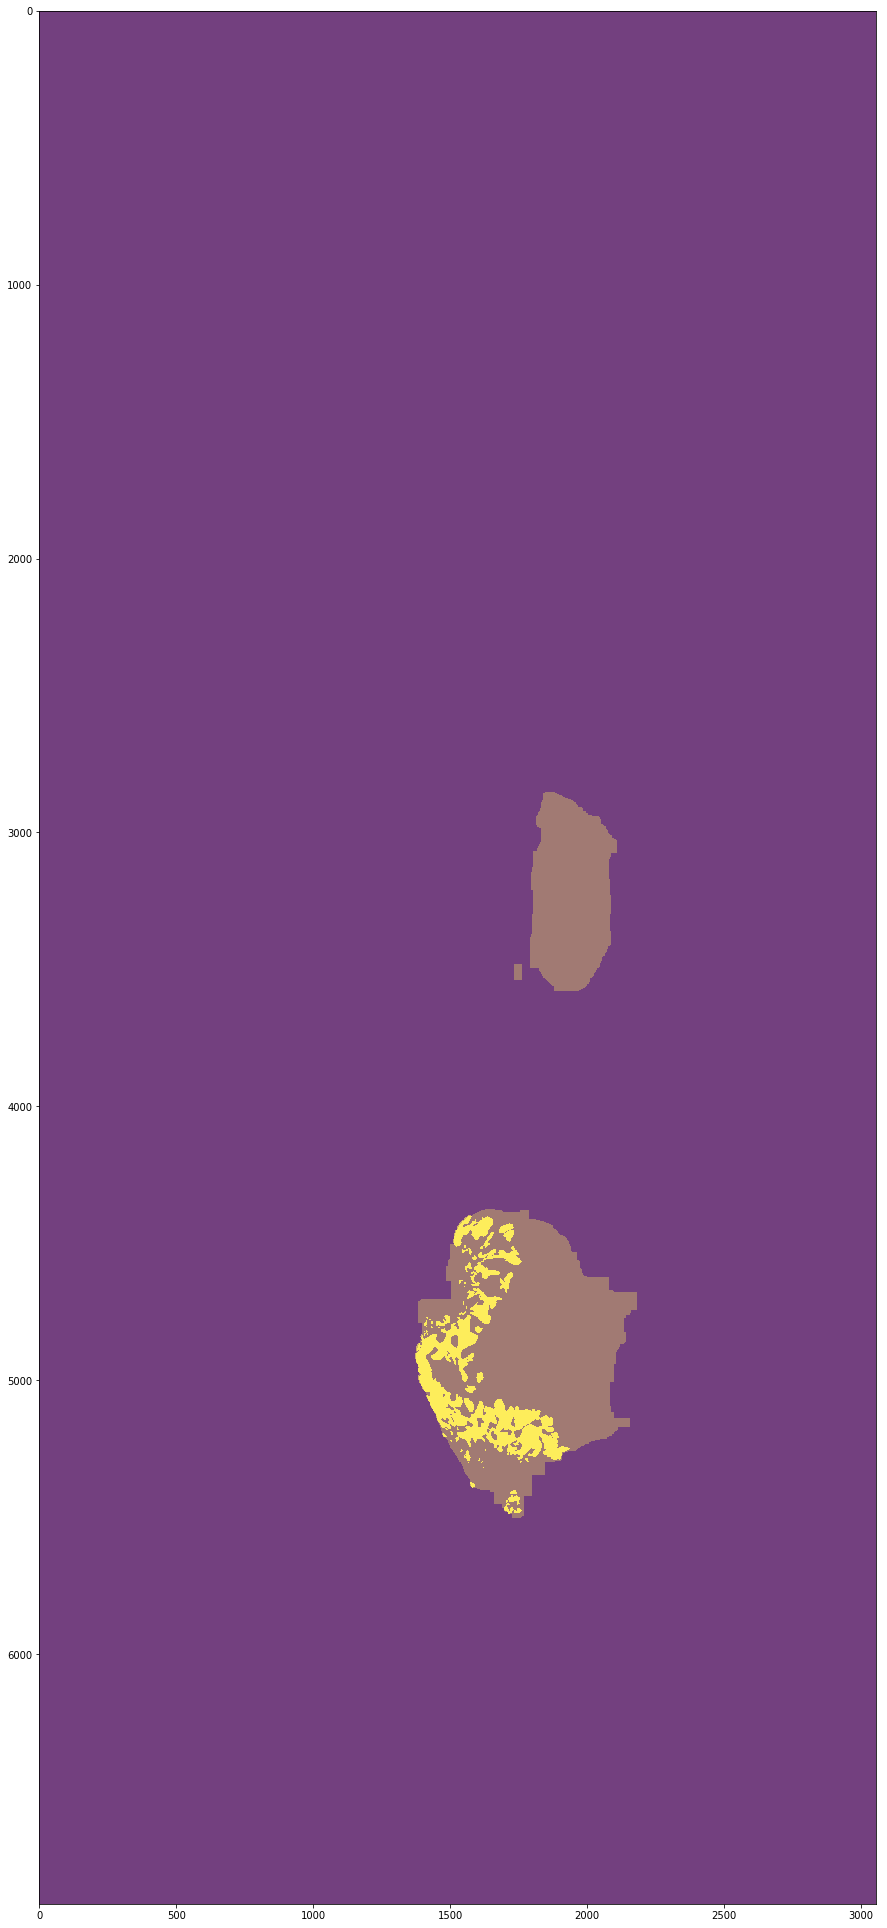

In [224]:
plt.figure(figsize=(15, 40))
# plt.imshow(sample_slide_img_arr)
plt.imshow(image_open_arr, alpha=0.5)
plt.imshow(sample_mask_arr, alpha=0.5)

In [225]:
# for slide_img_path in slide_img_paths:
#     slide = open_slide(slide_img_path)
#     image_open, contour_rgb = get_slide_with_bounding_box(slide)
#     image_open_arr = (np.asarray(image_open) / 255).astype(int)
    
#     base_name = os.path.basename(slide_img_path)
#     dest_file_name = 'zoom5_opening_mask_' + base_name.replace('.tif', '.npy')
    
#     np.save(os.path.join(DEST_DIR, dest_file_name), image_open_arr)
#     plt.figure(figsize=(15, 15))
#     plt.imshow(contour_rgb)
#     plt.imshow(image_open_arr, alpha=0.5)


In [156]:
image_open_arr.shape

(6864, 3056)

In [ ]:
contour_rgb.shape

In [ ]:
np.unique(image_open_arr)

In [ ]:
slide_pil_image = read_slide_pil(slide, 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=slide.level_dimensions[4][0], 
                         height=slide.level_dimensions[4][1])

In [ ]:
 slide_img = np.array(slide_pil_image)
    
hsv = cv2.cvtColor(slide_img, cv2.COLOR_BGR2HSV)
    # [20, 20, 20]
lower_red = np.array([30, 30, 30])
# [255, 255, 255]
upper_red = np.array([200, 200, 200])
mask = cv2.inRange(hsv, lower_red, upper_red)
res = cv2.bitwise_and(slide_img, slide_img, mask=mask)

# (50, 50)
close_kernel = np.ones((50, 50), dtype=np.uint8)
close_kernel_tmp = np.ones((30, 30), dtype=np.uint8)
image_close = Image.fromarray(cv2.morphologyEx(np.array(mask), cv2.MORPH_CLOSE, close_kernel))
image_close_tmp = Image.fromarray(cv2.morphologyEx(np.array(mask), cv2.MORPH_CLOSE, close_kernel_tmp))
# (30, 30)
open_kernel = np.ones((30, 30), dtype=np.uint8)
open_kernel_tmp = np.ones((30, 30), dtype=np.uint8)
image_open = Image.fromarray(cv2.morphologyEx(np.array(image_close), cv2.MORPH_OPEN, open_kernel))
image_open_tmp = Image.fromarray(cv2.morphologyEx(np.array(image_close_tmp), cv2.MORPH_OPEN, open_kernel_tmp))
contour_rgb, bounding_boxes, contour_rgb_tmp = get_normal_image_contours(np.array(image_open),
                                                                              slide_img,
                                                                              np.array(image_open_tmp))

In [ ]:
img_open_arr = np.asarray(image_open)

In [ ]:
img_open_arr.shape

In [ ]:
np.unique(img_open_arr)

In [ ]:
sample_img_open_arr = (img_open_arr / 255).astype(np.uint8)

In [ ]:
sample_img_open_arr.shape

In [ ]:
np.save('tumor_091_binary_img_opening.npy', sample_img_open_arr)

In [ ]:
#image_open

In [ ]:
slide_pil_with_bb, contour_rgb = get_slide_with_bouding_box(slide)
contour_pil = Image.fromarray(contour_rgb, 'RGB')
contour_arr = np.asarray(contour_pil)

In [ ]:
plt.figure(figsize=(15, 15))

plt.imshow(contour_arr)
#plt.imshow(img_open_arr, alpha=0.2)
plt.imshow(sample_img_open_arr, alpha=0.6)

In [ ]:
meta_file_path = '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/zoom_5_60_60_partition/meta/all_info_0.4_grayscale_tol.json'

In [ ]:
meta_df = pd.read_json(meta_file_path, dtype=False)

In [ ]:
meta_df = meta_df[meta_df['img_id'] == '091'].copy()

In [ ]:
meta_file_names = meta_df['file_name'].values

In [ ]:
slide.level_downsamples[4], slide.level_downsamples[5]

In [ ]:
is_roi_list = []

for file_name in meta_file_names:
    row_id = int(file_name.split('_')[-2])
    col_id = int(file_name.split('_')[-1].split('.')[0])
    
    x_start = row_id * 60 * 2
    x_end = x_start + 60 * 2
    y_start = col_id * 60 * 2
    y_end = y_start + 60 * 2
    
    opening_patch = sample_img_open_arr[x_start:x_end, y_start:y_end]
    
    if opening_patch.sum() > 1:
        is_roi = True
    else:
        is_roi = False
    
    is_roi_list.append(is_roi)

In [ ]:
meta_df['is_roi'] = is_roi_list

In [ ]:
roi_images = meta_df.loc[meta_df['is_roi'] == True, 'file_name'].values

In [ ]:
roi_images = sorted(roi_images)

In [ ]:
VAL_IMG_DIR = '../../../data/zoom_5_60_60_partition/test/slide/'

In [ ]:
is_roi_dict = meta_df.set_index('file_name')['is_roi'].to_dict()

In [ ]:
n_offsets = 2
fig, axes = plt.subplots(n_offsets * 2 + 1, n_offsets * 2 + 1, figsize=(15, 15))
# plt.tight_layout()
n_rows = 5
n_cols = 5

center_row = 4
center_col = 15

for i in range(n_rows):
    for j in range(n_cols):
        row = center_row - n_offsets + i
        col = center_col - n_offsets + j
        
        img_file = 'tumor_slide_{}_split_{}_{}.png'.format('091', row, col)
#         mask_file = 'tumor_mask_{}_split_{}_{}.npy'.format(img_id, row, col)
        
        img_arr = np.asarray(Image.open(os.path.join(VAL_IMG_DIR, img_file)))
#         mask_arr = np.load(os.path.join(VAL_MASK_DIR, mask_file))
        
        axes[i, j].set_axis_off()
        axes[i, j].imshow(img_arr)
        
        if is_roi_dict[img_file]:
            temp_mask = np.ones_like(img_arr)[:, :, 0]
            axes[i, j].imshow(temp_mask, alpha=0.8)
        
#         axes[i, j].imshow(mask_arr, alpha=0.2)